# 🏋️ Model Training

## ⚙️ Setup 

### 📚 Importing Libraries

Importing from packages

In [1]:
import os
import gc
import time
from dotenv import load_dotenv

import pandas as pd
import numpy as np
import torch
from torch import nn
import wandb
from pprint import pprint
import warnings

import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [2]:
os.chdir("../")
warnings.filterwarnings("ignore")
load_dotenv()

True

Importing user defined packages

In [3]:
from lib.config import config
from lib.paths import Paths
from lib.model.epoch_functions import train_epoch, valid_epoch
from lib.model.utils import get_score, get_model_optimizer_and_scheduler
from lib.utils.utils import seed_everything
from lib.data import read_data_loader_from_disk
from lib.criterion.metrics import log_metrics

In [4]:
pprint(config)

namespace(apex=True,
          batch_scheduler=True,
          batch_size_train=32,
          batch_size_valid=32,
          betas=[0.9, 0.999],
          data_version=5,
          debug=False,
          decoder_lr=2e-05,
          encoder_lr=2e-05,
          epochs=2,
          eps=1e-06,
          gradient_accumulation_steps=1,
          gradient_checkpointing=True,
          max_grad_norm=1000,
          max_length=512,
          min_lr=1e-06,
          model='microsoft/deberta-v3-base',
          n_folds=5,
          negative_sample=True,
          negative_sample_partitions=3,
          num_classes=6,
          num_cycles=0.5,
          num_warmup_steps=0,
          num_workers=6,
          positive_classes=[0, 5],
          negative_classes=[1, 2, 3, 4],
          print_freq=6,
          random_seed=20,
          scheduler='cosine',
          stride=192,
          tokenizer_version=2,
          train=True,
          train_folds=[0, 1, 2, 3, 4, 5, 6, 7],
          weight_decay=0.0

In [5]:
seed_everything()

### Setting Up WandB

In [6]:
WANDB_PROJECT = "Kaggle_ASE_2.0"
model_name = config.model.split("/")[-1]
WANDB_NAME = f"{model_name}-{config.max_length}-D{config.data_version}-T{config.tokenizer_version}"

In [7]:
wandb.login(key=os.environ.get('WANDB_API_KEY'))
wandb.init(
    project=WANDB_PROJECT,
    name=WANDB_NAME,
    save_code=True,
    job_type="train",
    config=config,
)
config = wandb.config

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: shakleenishfar (laplacesdemon43). Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /home/ishfar/.netrc


## 📖 Definitions

### 🌎 Global Variables

In [8]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

The competition data has a class imbalance problem. Which is why I assign higher weights to classes having lower samples.

In [9]:
# class_weights = torch.tensor([1.0, 0.25, 0.25, 0.5, 1.0, 2.0]).to(device)
class_weights = torch.tensor([1.0] * 6).to(device)

### 🛠️ Functions

In [10]:
def train_loop(fold):
    print(f"========== Fold: {fold} training ==========")

    # ======== DATA LOADER ==========
    train_loader, valid_loader = read_data_loader_from_disk(fold)
    valid_fold = pd.read_csv(os.path.join(Paths.DATA_LOADER_PATH, f"valid_{fold}.csv"))
    valid_labels = valid_fold["score"].values

    # ======== MODEL ==========
    model, optimizer, scheduler = get_model_optimizer_and_scheduler(
        train_loader, device
    )

    # ======= LOSS ==========
    # criterion = RMSELoss(reduction="mean") # nn.SmoothL1Loss(reduction='mean')
    criterion = nn.CrossEntropyLoss(weight=class_weights)
    softmax = nn.Softmax(dim=1)

    best_score = -np.inf
    # ====== ITERATE EPOCHS ========
    for epoch in range(config.epochs):
        start_time = time.time()

        # ======= TRAIN ==========
        avg_loss = train_epoch(
            fold,
            train_loader,
            model,
            criterion,
            optimizer,
            epoch,
            scheduler,
            device,
        )

        # ======= EVALUATION ==========
        avg_val_loss, prediction_dict = valid_epoch(
            fold, valid_loader, model, criterion, device
        )
        predictions = prediction_dict["predictions"]
        _, predictions = torch.max(softmax(torch.tensor(predictions)), dim=1)

        # ======= SCORING ==========
        score = get_score(valid_labels, predictions)

        wandb.log(
            {
                f"eval/eval_epoch_f{fold}": epoch + 1,
                f"eval/eval_loss_f{fold}": avg_val_loss,
                f"eval/qwk_score_f{fold}": score,
            }
        )

        elapsed = time.time() - start_time

        print(
            f"Epoch {epoch+1} - avg_train_loss: {avg_loss:.4f}  avg_val_loss: {avg_val_loss:.4f}  time: {elapsed:.0f}s"
        )
        print(f"Epoch {epoch+1} - Score: {score:.4f}")

        if score > best_score:
            best_score = score
            print(f"Epoch {epoch+1} - Save Best Score: {best_score:.4f} Model")
            torch.save(
                {"model": model.state_dict(), "predictions": predictions},
                Paths.MODEL_OUTPUT_PATH
                + f"/{config.model.replace('/', '_')}_fold_{fold}_best.pth",
            )

    predictions = torch.load(
        Paths.MODEL_OUTPUT_PATH
        + f"/{config.model.replace('/', '_')}_fold_{fold}_best.pth",
        map_location=torch.device("cpu"),
    )["predictions"]
    valid_fold["pred_score"] = predictions

    del model, optimizer, scheduler, criterion, softmax
    torch.cuda.empty_cache()
    gc.collect()

    return valid_fold

In [11]:
def get_result(oof_df):
    labels = oof_df["score"].values
    preds = oof_df["pred_score"].values
    score = get_score(labels, preds)
    print(f'Score: {score:<.4f}')
    return score

## 🏁 Start Training

In [12]:
if config.train:
    oof_df = pd.DataFrame()

    for fold in range(config.n_folds):
        if fold in config.train_folds:
            _oof_df = train_loop(fold)
            log_metrics(_oof_df, f"Fold {fold}")
            oof_df = pd.concat([oof_df, _oof_df])
            print(f"========== Fold: {fold} result ==========")
            get_result(_oof_df)

    oof_df = oof_df.reset_index(drop=True)
    print(f"========== CV ==========")
    score = get_result(oof_df)
    wandb.log({"CV/qwk_score": score})
    oof_df.to_csv(Paths.MODEL_OUTPUT_PATH + "/oof_df.csv", index=False)

========== Fold: 0 training ==========


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Validating Fold 0: 100%|██████████| 149/149 [00:59<00:00,  2.49valid_batch/s]


Epoch 1 - avg_train_loss: 0.9728  avg_val_loss: 0.9623  time: 989s
Epoch 1 - Score: 0.7759
Epoch 1 - Save Best Score: 0.7759 Model


Validating Fold 0: 100%|██████████| 149/149 [00:55<00:00,  2.70valid_batch/s]


Epoch 2 - avg_train_loss: 0.7914  avg_val_loss: 0.9144  time: 933s
Epoch 2 - Score: 0.7842
Epoch 2 - Save Best Score: 0.7842 Model
========== Fold: 0 result ==========
Score: 0.7842
========== Fold: 1 training ==========


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Validating Fold 1: 100%|██████████| 150/150 [00:54<00:00,  2.77valid_batch/s]


Epoch 1 - avg_train_loss: 0.9616  avg_val_loss: 0.8933  time: 919s
Epoch 1 - Score: 0.8084
Epoch 1 - Save Best Score: 0.8084 Model


Validating Fold 1: 100%|██████████| 150/150 [00:58<00:00,  2.57valid_batch/s]


Epoch 2 - avg_train_loss: 0.7898  avg_val_loss: 0.9427  time: 940s
Epoch 2 - Score: 0.7930
========== Fold: 1 result ==========
Score: 0.8084
========== Fold: 2 training ==========


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Validating Fold 2: 100%|██████████| 149/149 [00:55<00:00,  2.67valid_batch/s]


Epoch 1 - avg_train_loss: 0.9669  avg_val_loss: 1.1042  time: 946s
Epoch 1 - Score: 0.7297
Epoch 1 - Save Best Score: 0.7297 Model


Validating Fold 2: 100%|██████████| 149/149 [00:56<00:00,  2.63valid_batch/s]


Epoch 2 - avg_train_loss: 0.7951  avg_val_loss: 0.9431  time: 972s
Epoch 2 - Score: 0.8081
Epoch 2 - Save Best Score: 0.8081 Model
========== Fold: 2 result ==========
Score: 0.8081
========== Fold: 3 training ==========


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Validating Fold 3: 100%|██████████| 148/148 [00:53<00:00,  2.75valid_batch/s]


Epoch 1 - avg_train_loss: 0.9559  avg_val_loss: 0.8653  time: 959s
Epoch 1 - Score: 0.8280
Epoch 1 - Save Best Score: 0.8280 Model


Validating Fold 3: 100%|██████████| 148/148 [00:53<00:00,  2.75valid_batch/s]


Epoch 2 - avg_train_loss: 0.7619  avg_val_loss: 0.8579  time: 935s
Epoch 2 - Score: 0.8091
========== Fold: 3 result ==========
Score: 0.8280
========== Fold: 4 training ==========


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Validating Fold 4: 100%|██████████| 150/150 [00:59<00:00,  2.54valid_batch/s]


wandb: Network error resolved after 0:00:01.215327, resuming normal operation.


Epoch 1 - avg_train_loss: 0.9624  avg_val_loss: 0.9797  time: 939s
Epoch 1 - Score: 0.8022
Epoch 1 - Save Best Score: 0.8022 Model


Validating Fold 4: 100%|██████████| 150/150 [01:01<00:00,  2.45valid_batch/s]


Epoch 2 - avg_train_loss: 0.8040  avg_val_loss: 0.9014  time: 1001s
Epoch 2 - Score: 0.7970
========== Fold: 4 result ==========
Score: 0.8022
========== CV ==========
Score: 0.8066


In [13]:
wandb.log({"oof_table": wandb.Table(dataframe=oof_df)})

## Evaluate

In [14]:
log_metrics(oof_df, "Overall")

### Confusion Matrix

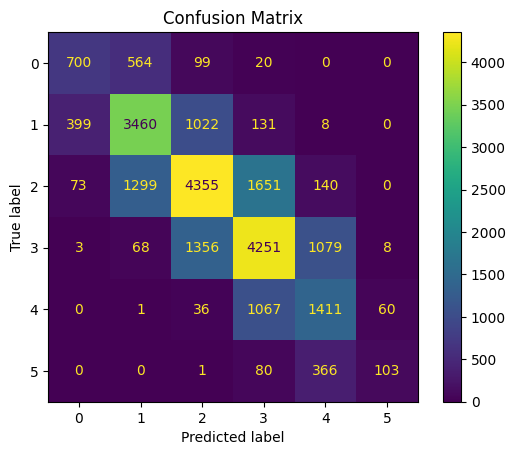

In [15]:
cm = confusion_matrix(oof_df["score"], oof_df["pred_score"])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(range(config.num_classes)))

# Plot the confusion matrix
disp.plot(cmap='viridis', values_format='d')
plt.title("Confusion Matrix")
plt.show()

Finish experiment

In [20]:
wandb.finish()

CV/qwk_score,▁
eval/eval_epoch_f0,▁█
eval/eval_epoch_f1,▁█
eval/eval_epoch_f2,▁█
eval/eval_epoch_f3,▁█
eval/eval_epoch_f4,▁█
eval/eval_loss_f0,█▁
eval/eval_loss_f1,▁█
eval/eval_loss_f2,█▁
eval/eval_loss_f3,█▁
eval/eval_loss_f4,█▁
